## Assignment 1 
### Trusha a1813762

In [1]:
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords 
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from nltk.stem import WordNetLemmatizer
import re
import collections
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, StratifiedKFold
import sklearn.naive_bayes
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import learning_curve
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 1. Reading datasets

In [2]:
train_file = open("reviews_train.txt", encoding = "latin-1")
test_file = open("reviews_test.txt", encoding = "latin-1")

In [3]:
train_data = train_file.readlines()
test_data = test_file.readlines()

In [4]:
train_data_strip = []
for i,j in enumerate(train_data):
        train_data_strip.append(j.strip("\n"))
        

test_data_strip = []
for i,j in enumerate(test_data):
        test_data_strip.append(j.strip("\n"))

In [5]:
X_train = []
X_test = []
y_train = []
y_test = []

for i,j in enumerate(train_data_strip):
#     strip_j = j.strip("\n")
    words_train = j.split()
    y_train.append(words_train[0])
    X_train.append(words_train[1:])
    X_train[i] = " ".join(X_train[i])
    
for i,j in enumerate(test_data_strip):
#     strip_j = j.strip("\n")
    words_test = j.split()
    y_test.append(words_test[0])
    X_test.append(words_test[1:])
    X_test[i] = " ".join(X_test[i])

In [6]:
y_train = list(map(lambda x: x.replace('__label__1', 'negative'), y_train))
y_train = list(map(lambda x: x.replace('__label__2', 'positive'), y_train))
# y_train
y_test = list(map(lambda x: x.replace('__label__1', 'negative'), y_test))
y_test = list(map(lambda x: x.replace('__label__2', 'positive'), y_test))
# y_test

### 2. Pre-processing

In [7]:
# Version 1 : Remove punctuation, stopwords, non-alphanumeric characters

# Punctuation
X_train_punctuation = [line.translate(line.maketrans('', '', string.punctuation)) for line in X_train]
X_test_punctuation = [line.translate(line.maketrans('', '', string.punctuation)) for line in X_test]

# Tokenize 
X_train_token = [word_tokenize(text) for text in X_train_punctuation]
X_test_token = [word_tokenize(text) for text in X_test_punctuation]



In [8]:
# non-alphanumeric
X_train_alpha = [[re.sub(r'[^a-zA-Z0-9]','',i)for i in line ] for line in X_train_token]
X_test_alpha = [[re.sub(r'[^a-zA-Z0-9]', '', i) for i in line] for line in X_test_token]

In [9]:
# Stopwords
stop_words = set(stopwords.words('english'))
X_train_version1 = [[word for word in line if word.lower() not in stop_words]for line in X_train_alpha]
X_test_version1 = [[word for word in line if word.lower() not in stop_words]for line in X_test_alpha]

In [10]:
# Version 2 : Lowercase 
X_train_version2 = [[word.lower() for word in line]for line in X_train_version1]
X_test_version2 = [[word.lower() for word in line]for line in X_test_version1]

In [11]:
# Version 3 : Lemmetization
lemmatizer = WordNetLemmatizer()
X_train_version3 = [[lemmatizer.lemmatize(word) for word in line]for line in X_train_version2]
X_test_version3 = [[lemmatizer.lemmatize(word) for word in line]for line in X_test_version2]

### 3. Dataset analysis

Proportions of the labels in the Training dataset
Positive count : 149698
Negative count : 150302


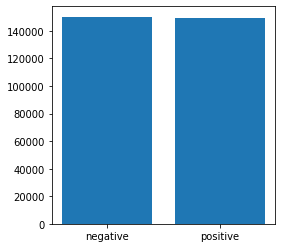

In [12]:
# Proportion of labels in training dataset
y_train_word_freq = Counter(y_train)

print ("Proportions of the labels in the Training dataset") 
print(f'Positive count : {y_train_word_freq["positive"]}')
print(f'Negative count : {y_train_word_freq["negative"]}')

plt.figure(figsize=(4,4))
plt.bar(y_train_word_freq.keys(), y_train_word_freq.values())
plt.show()

Proportions of the labels in the Testing dataset
Positive count : 50302
Negative count : 49698


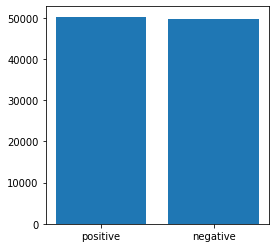

In [13]:
#Proportion of labels in testing dataset
y_test_word_freq = Counter(y_test)

print ("Proportions of the labels in the Testing dataset") 
print(f'Positive count : {y_test_word_freq["positive"]}')
print(f'Negative count : {y_test_word_freq["negative"]}')

plt.figure(figsize=(4,4))
plt.bar(y_test_word_freq.keys(), y_test_word_freq.values())
plt.show()

Analysis of the dataset reveals that there is a balanced distribution of positive and negative sentiment in both the training and testing sets. The training set has a positive to negative sentiment ratio of 49.9% to 50.1%, while the testing set has a positive to negative sentiment ratio of 50.3% to 49.7%.

A more thorough evaluation of the model's performance can be obtained by using metrics like precision, recall, and F1-score that take both false positives and false negatives into account.

The class imbalance problem is less likely to arise if the ratio of positive and negative labels is nearly equal in both the training and testing sets. Accuracy, precision, recall, and F1-score are examples of performance metrics that can be used to evaluate the effectiveness of the model in this situation.

In [14]:
# Unique words

def unique_words(list_of_lists):
    unique_set = set()
    for l in list_of_lists:
        for word in l:
            unique_set.add(word)
    return unique_set


unique_version1 = unique_words(X_train_version1)
unique_version2 = unique_words(X_train_version2)
unique_version3 = unique_words(X_train_version3)

print(f'Unique words in version 1: {len(unique_version1)}')
print(f'Unique words in version 2: {len(unique_version2)}')
print(f'Unique words in version 3: {len(unique_version3)}')

Unique words in version 1: 488912
Unique words in version 2: 401735
Unique words in version 3: 387308


In [15]:
#Converting list of Tokens into sentences
X_train_version1_sent = [" ".join(word) for word in X_train_version1]
X_train_version2_sent = [" ".join(word) for word in X_train_version2]
X_train_version3_sent = [" ".join(word) for word in X_train_version3]

X_test_version1_sent = [" ".join(word) for word in X_test_version1]
X_test_version2_sent = [" ".join(word) for word in X_test_version2]
X_test_version3_sent = [" ".join(word) for word in X_test_version3]

### 4. Sentiment classification using Machine Learning

In [17]:
# Vectorize the text
vectorizer = TfidfVectorizer(lowercase = False)

X_train_version1_sent_vec = vectorizer.fit_transform(X_train_version1_sent)
X_test_version1_sent_vec = vectorizer.transform(X_test_version1_sent)

X_train_version2_sent_vec = vectorizer.fit_transform(X_train_version2_sent)
X_test_version2_sent_vec = vectorizer.transform(X_test_version2_sent)

X_train_version3_sent_vec = vectorizer.fit_transform(X_train_version3_sent)
X_test_version3_sent_vec  = vectorizer.transform(X_test_version3_sent)

In [28]:
def multinomial_model(X_train_value, y_train_value, X_test_value, y_test_value):
    
    multinomial_model = MultinomialNB()
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    fitted_model_score = cross_validate(multinomial_model, X_train_value, y_train_value, cv = cv, scoring = "accuracy", return_train_score = True)
    train_acc = np.mean(fitted_model_score['train_score'])
    val_acc = np.mean(fitted_model_score['test_score'])
    multinomial_model.fit(X_train_value, y_train_value)
    y_pred = multinomial_model.predict(X_test_value)
    test_acc = accuracy_score(y_test_value, y_pred)

    # Calculate learning curve
    train_sizes, train_scores, val_scores = learning_curve(
      multinomial_model, X_train_value, y_train_value, cv=5, scoring='accuracy', n_jobs=-1,
      train_sizes=np.linspace(0.1, 1.0, 10)
      )

    # Plot learning curve
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training accuracy')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return (train_acc, val_acc, test_acc)

Multinomial_model

For Version 1:



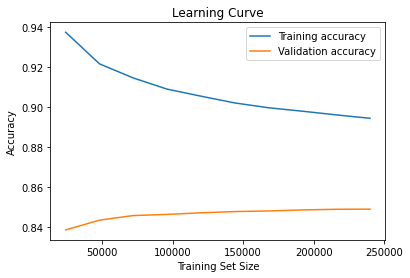

Training Accuracy score : 0.8487633333333333
Validation Accuracy score : 0.8944841666666667
Testing Accuracy score : 0.84832

For Version 2:



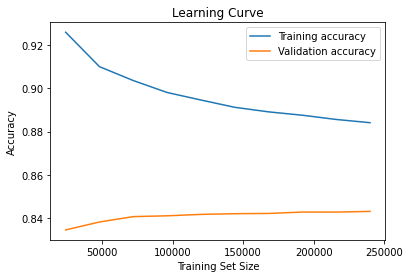

Training Accuracy score : 0.8430533333333333
Validation Accuracy score : 0.8842766666666666
Testing Accuracy score : 0.84149

For Version 3:



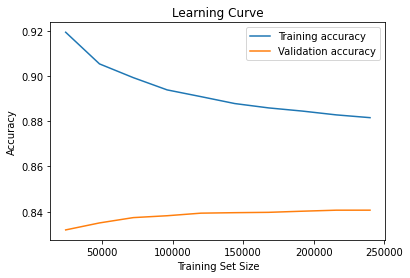

Training Accuracy score : 0.8407900000000001
Validation Accuracy score : 0.8816208333333332
Testing Accuracy score : 0.84055


In [29]:
print("Multinomial_model")
print("\nFor Version 1:\n")
train_acc_version1_multi, val_acc_version1_multi, test_acc_version1_multi = multinomial_model(X_train_version1_sent_vec, y_train, X_test_version1_sent_vec, y_test)
print(f"Training Accuracy score : {val_acc_version1_multi}")
print(f"Validation Accuracy score : {train_acc_version1_multi}")
print(f"Testing Accuracy score : {test_acc_version1_multi}")

print("\nFor Version 2:\n")
train_acc_version2_multi, val_acc_version2_multi, test_acc_version2_multi = multinomial_model(X_train_version2_sent_vec, y_train, X_test_version2_sent_vec, y_test)
print(f"Training Accuracy score : {val_acc_version2_multi}")
print(f"Validation Accuracy score : {train_acc_version2_multi}")
print(f"Testing Accuracy score : {test_acc_version2_multi}")

print("\nFor Version 3:\n")
train_acc_version3_multi, val_acc_version3_multi, test_acc_version3_multi = multinomial_model(X_train_version3_sent_vec, y_train, X_test_version3_sent_vec, y_test)
print(f"Training Accuracy score : {val_acc_version3_multi}")
print(f"Validation Accuracy score : {train_acc_version3_multi}")
print(f"Testing Accuracy score : {test_acc_version3_multi}")

In [30]:
def bernoulli_model(X_train_value, y_train_value, X_test_value, y_test_value):
    
    bernoulli_model = BernoulliNB()
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    fitted_model_score = cross_validate(bernoulli_model, X_train_value, y_train_value, cv = cv, scoring = "accuracy", return_train_score = True)
    train_acc = np.mean(fitted_model_score['train_score'])
    val_acc = np.mean(fitted_model_score['test_score'])
    bernoulli_model.fit(X_train_value, y_train_value)
    y_pred = bernoulli_model.predict(X_test_value)
    test_acc = accuracy_score(y_test_value, y_pred)

    # Calculate learning curve
    train_sizes, train_scores, val_scores = learning_curve(
      bernoulli_model, X_train_value, y_train_value, cv=5, scoring='accuracy', n_jobs=-1,
      train_sizes=np.linspace(0.1, 1.0, 10)
      )

    # Plot learning curve
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training accuracy')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return (train_acc, val_acc, test_acc)

Bernoulli_model 

For Version 1:



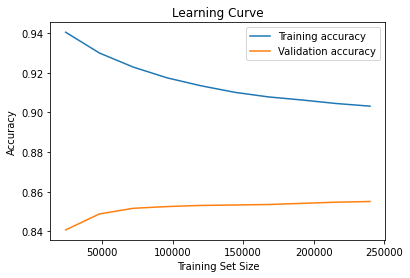

Training Accuracy score : 0.8550633333333334
Validation Accuracy score : 0.9032666666666668
Testing Accuracy score : 0.85665

For Version 2:



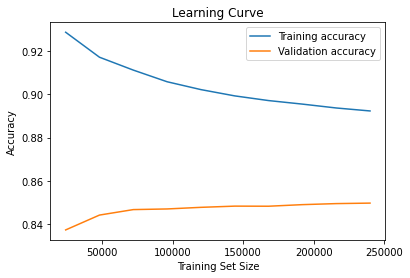

Training Accuracy score : 0.8496666666666666
Validation Accuracy score : 0.8922908333333334
Testing Accuracy score : 0.85082

For Version 3:



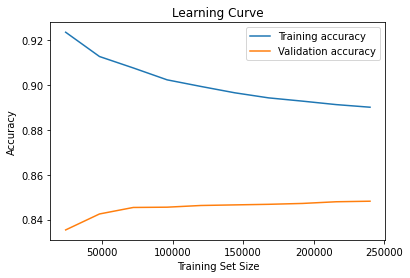

Training Accuracy score : 0.8481500000000001
Validation Accuracy score : 0.8900141666666667
Testing Accuracy score : 0.84881


In [31]:
print("Bernoulli_model ")
print("\nFor Version 1:\n")
train_acc_version1_ber, val_acc_version1_ber, test_acc_version1_ber = bernoulli_model(X_train_version1_sent_vec, y_train, X_test_version1_sent_vec, y_test)
print(f"Training Accuracy score : {val_acc_version1_ber}")
print(f"Validation Accuracy score : {train_acc_version1_ber}")
print(f"Testing Accuracy score : {test_acc_version1_ber}")

print("\nFor Version 2:\n")
train_acc_version2_ber, val_acc_version2_ber, test_acc_version2_ber = bernoulli_model(X_train_version2_sent_vec, y_train, X_test_version2_sent_vec, y_test)
print(f"Training Accuracy score : {val_acc_version2_ber}")
print(f"Validation Accuracy score : {train_acc_version2_ber}")
print(f"Testing Accuracy score : {test_acc_version2_ber}")

print("\nFor Version 3:\n")
train_acc_version3_ber, val_acc_version3_ber, test_acc_version3_ber = bernoulli_model(X_train_version3_sent_vec, y_train, X_test_version3_sent_vec, y_test)
print(f"Training Accuracy score : {val_acc_version3_ber}")
print(f"Validation Accuracy score : {train_acc_version3_ber}")
print(f"Testing Accuracy score : {test_acc_version3_ber}")

In [32]:
def logistic_regression_model(X_train_value, y_train_value, X_test_value, y_test_value):
    
    logisticregression_model = LogisticRegression(max_iter = 1000)
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    fitted_model_score = cross_validate(logisticregression_model, X_train_value, y_train_value, cv = cv, scoring = "accuracy", return_train_score = True)
    train_acc = np.mean(fitted_model_score['train_score'])
    val_acc = np.mean(fitted_model_score['test_score'])
    logisticregression_model.fit(X_train_value, y_train_value)
    y_pred = logisticregression_model.predict(X_test_value)
    test_acc = accuracy_score(y_test_value, y_pred)

    # Calculate learning curve
    train_sizes, train_scores, val_scores = learning_curve(
      logisticregression_model, X_train_value, y_train_value, cv=5, scoring='accuracy', n_jobs=-1,
      train_sizes=np.linspace(0.1, 1.0, 10)
      )

    # Plot learning curve
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training accuracy')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return (train_acc, val_acc, test_acc)

Logistic_regression_model 

For Version 1:



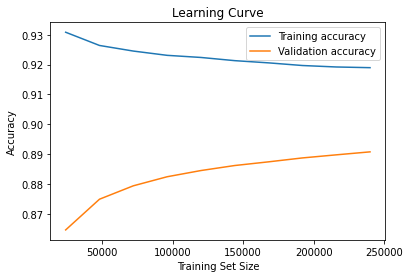

Training Accuracy score : 0.8910333333333333
Validation Accuracy score : 0.9189225000000001
Testing Accuracy score : 0.89354

For Version 2:



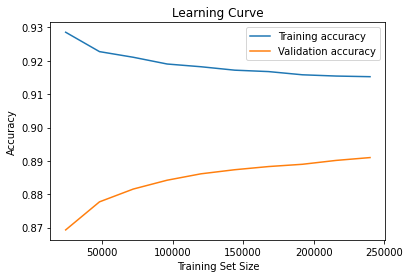

Training Accuracy score : 0.8908166666666666
Validation Accuracy score : 0.9152549999999999
Testing Accuracy score : 0.89421

For Version 3:



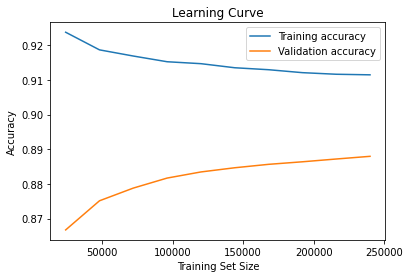

Training Accuracy score : 0.88788
Validation Accuracy score : 0.9116333333333333
Testing Accuracy score : 0.89084


In [33]:
print("Logistic_regression_model ")
print("\nFor Version 1:\n")
train_acc_version1_log, val_acc_version1_log, test_acc_version1_log = logistic_regression_model(X_train_version1_sent_vec, y_train, X_test_version1_sent_vec, y_test)
print(f"Training Accuracy score : {val_acc_version1_log}")
print(f"Validation Accuracy score : {train_acc_version1_log}")
print(f"Testing Accuracy score : {test_acc_version1_log}")

print("\nFor Version 2:\n")
train_acc_version2_log, val_acc_version2_log, test_acc_version2_log = logistic_regression_model(X_train_version2_sent_vec, y_train, X_test_version2_sent_vec, y_test)
print(f"Training Accuracy score : {val_acc_version2_log}")
print(f"Validation Accuracy score : {train_acc_version2_log}")
print(f"Testing Accuracy score : {test_acc_version2_log}")

print("\nFor Version 3:\n")
train_acc_version3_log, val_acc_version3_log, test_acc_version3_log = logistic_regression_model(X_train_version3_sent_vec, y_train, X_test_version3_sent_vec, y_test)
print(f"Training Accuracy score : {val_acc_version3_log}")
print(f"Validation Accuracy score : {train_acc_version3_log}")
print(f"Testing Accuracy score : {test_acc_version3_log}")


Three classification techniques—Multinomial NB, Bernoulli NB and Logistic Regression—were tested.

For performance comparison of the model on each version, we used cross-validation with five folds, and the average accuracy score was used as the final metric. In addition, we used stratified K fold to keep the positive:negative fold ratio constant.

**Multinomial NB** : After calculating accuracy score it was seen that the very first version gives good results with training accuracy as 84.9% and test accuracy as 84.8%

**Bernoulli NB** : for bernoulli model the trainging accuracy score was 85.5% and testing accuracy score was 85.7%, which is better than the multinomial model but still there is no significant difference between them.

**Logistic regression** : The best result was given by logistic regression model which gave training accuracy as 89.1% which is less than testing accuracy which came in as 89.3%. But while looking at the curve it can be seen that this model is slight overfitting and long runtime.

As a result, bernoulli and multinomial model performed pretty much the same but bernoulli model gave a little better accuracies then the other one so, going forward with **Bernoulli as the best model**.



### 5. Sentiment classification using VADER sentiment lexicon

In [37]:
def VADER_analysis(test):
  analyser = SentimentIntensityAnalyzer()
  y_pred = []
  for text in test:
      score = analyser.polarity_scores(text)
      if score['compound'] >= 0:
          y_pred.append("positive")
      else:
          y_pred.append("negative")
  return y_pred

def print_acc_metrics(y_pred,y_test):
  f1 = f1_score(y_test, y_pred, average="weighted")
  print(f"f1 score : {f1}")
  prec = precision_score(y_test, y_pred, average="weighted")
  print(f"precision : {prec}")
  rec = recall_score(y_test, y_pred, average="weighted")
  print(f"recall : {rec}")
  acc = accuracy_score(y_test, y_pred)
  print(f"accuracy : {acc}")
  return acc

print("\nVersion 1:\n")
y_pred_ver1 = VADER_analysis(X_test_version1_sent)
vader_version1 = print_acc_metrics(y_pred_ver1,y_test)

print("\nVersion 2:\n")
y_pred_ver2 = VADER_analysis(X_test_version2_sent)
vader_version2 = print_acc_metrics(y_pred_ver2,y_test)

print("\nVersion 3:\n")
y_pred_ver3 = VADER_analysis(X_test_version3_sent)
vader_version3 = print_acc_metrics(y_pred_ver3,y_test)

test_accs =[vader_version1,vader_version2,vader_version3]

rows = ["Version 1","Version 2","Version 3"]

print("Classification results using VADER ")
vader_df = pd.DataFrame(list(zip(rows, test_accs)),columns = ["","Testing"])
vader_df


Version 1:

f1 score : 0.6504195025600359
precision : 0.7410295390930333
recall : 0.67513
accuracy : 0.67513

Version 2:

f1 score : 0.6501689147476533
precision : 0.7409272071195315
recall : 0.67494
accuracy : 0.67494

Version 3:

f1 score : 0.6498364907654697
precision : 0.7416291793477571
recall : 0.67485
accuracy : 0.67485
Classification results using VADER 


,,Testing
0,Version 1,0.67513
1,Version 2,0.67494
2,Version 3,0.67485


When comparing the results obtained by using VADER with the previously selected best model which is Bernoulli, it can be seen that it is not giving better accuracy instead it's even less around 67%. 

Thus, as a result it can be said that VADER can be used but for complex sentiment analysis Bernoulli classifier works best.

### 6. (optional challenge 3 points) Combine VADER with the classifier

### 7. References

https://towardsdatascience.com/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6

https://www.analyticsvidhya.com/blog/2021/07/performing-sentiment-analysis-with-naive-bayes-classifier/

https://www.analyticsvidhya.com/blog/2022/11/explaining-sparse-datasets-with-practical-examples/